# Setup for SAGA code

In [1]:
import os
import sys

working_dir = os.path.abspath('..')

In [2]:
%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
copying SAGA/quickstart.py -> build/lib/SAGA
copying SAGA/version.py -> build/lib/SAGA
copying SAGA/database/core.py -> build/lib/SAGA/database
copying SAGA/database/external.py -> build/lib/SAGA/database
copying SAGA/database/saga_database.py -> build/lib/SAGA/database
copying SAGA/hosts/build.py -> build/lib/SAGA/hosts
copying SAGA/hosts/cuts.py -> build/lib/SAGA/hosts
copying SAGA/hosts/host_catalog.py -> build/lib/SAGA/hosts
copying SAGA/objects/build.py -> build/lib/SAGA/objects
copying SAGA/objects/build2.py -> build/lib/SAGA/objects
copying SAGA/objects/cuts.py -> build/lib/SAGA/objects
copying SAGA/objects/object_catalog.py -> build/lib/SAGA/objects
copying SAGA/spectra/manual_fixes.py -> build/lib/SAGA/spectra
copying SAGA/spectra/read_external.py -> build/lib/SAGA/spectra
copying SAGA/targets/assign_targeting_score.py -> build/lib/SAGA/targets
copying SAGA/utils/display.py -> build/lib/SAGA/utils
/Users/erik/projec

In [3]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga
saga.__version__

Adding /Users/erik/projects/saga/saga/build/lib to the python path


'0.14.2'

In [4]:
import numpy as np


% matplotlib inline
import matplotlib.pyplot as plt

Style consistency w/ yao

In [5]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4

# Host sets

In [6]:
from easyquery import Query

In [7]:
sagaqs = saga.QuickStart()
hosts_with_stats = sagaqs.host_catalog.load(include_stats=True)
completed_hosts = Query("really_need_spec < 40").filter(hosts_with_stats)
observed_hosts = Query("specs_ours > 10").filter(hosts_with_stats)

SAGA `shared_dir` set to /Users/erik/projects/saga/erik
SAGA `local_dir`  set to /Users/erik/projects/saga/erik


# Radial Distribution

In [8]:
def nfw(x, c=10):
    return (np.log1p(c*x) - c*x/(1.0+c*x)) / (np.log1p(c) - c/(1.0+c))
def cap_at_one(x):
    return np.where(x>1, 1, x)

## Yao's plot  

In [9]:
# needs saga version >= 0.14.1
from SAGA.database import FitsTable
from easyquery import Query, QueryMaker

In [10]:
sats = FitsTable("https://www.dropbox.com/s/05f73ou70i9mw4d/saga_sats_201911.fits?dl=1").read()
sats_completed_hosts = QueryMaker.in1d("HOSTID", completed_hosts["HOSTID"]).filter(sats)

In [11]:
r_kpc = Query('Mr < -12.3').filter(sats_completed_hosts, 'RHOST_KPC')
r_kpc.sort()

In [12]:
len(r_kpc)

76

In [13]:
rbins = np.logspace(1, 2.5, 1000)

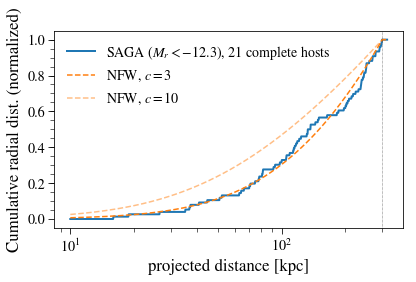

In [14]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized)')
plt.tight_layout()

## Add LG Rfs

In [15]:
from astropy import units as u
from astropy.coordinates import Galactocentric, CartesianRepresentation, SphericalRepresentation, ICRS, SkyCoord

In [16]:
m31 = ICRS(10.68470833*u.deg, 41.26875*u.deg, distance=700*u.kpc)

In [17]:
mcconn_path = os.path.join(os.environ['HOME'], 'astrodata/mcconn12_nearbydwarfs')
sys.path.insert(1, mcconn_path)

import nearbygals
mcconn_tab = nearbygals.get_table()
mcconn_tab

name,center,EBmV,distmod,distmod+,distmod-,vh,vh+,vh-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e,e+,e-,muV0,muV0+,muV0-,rh,rh+,rh-,sigma_s,sigma_s+,sigma_s-,vrot_s,vrot_s+,vrot_s-,MHI,sigma_g,sigma_g+,sigma_g-,vrot_g,vrot_g+,vrot_g-,[Fe/H],[Fe/H]+,[Fe/H]-,F,References,Vabs,logLV,distance,distance+,distance-,rh_phys,radeg,decdeg,x,y,z,and_number
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,solLum,kpc,kpc,kpc,kpc,deg,deg,kpc,kpc,kpc,
bytes19,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
Canis Major,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (108.14583333, -27.66666667, 7.21107479)>",0.264,14.29,0.3,0.3,87.0,4.0,4.0,-0.1,0.8,0.8,123.0,99.9,99.9,9.99,9.99,9.99,24.0,0.6,0.6,99.99,9.99,9.99,20.0,3.0,3.0,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-0.5,0.2,0.2,4,(1)(2)(95)(176),-14.389999999999999,7.688,7.21107479182899,0.9962467992078345,0.9962467992078345,0.2097406867086801,108.14583333333331,-27.666666666666668,-1.9890180319661466,6.068963868491208,-3.348295758264681,-99
Sagittarius dSph,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (283.83125, -30.54527778, 26.30267992)>",0.153,17.1,0.15,0.15,140.0,2.0,2.0,3.6,0.3,0.3,102.0,2.0,2.0,0.64,0.02,0.02,25.2,0.3,0.3,342.0,12.0,12.0,11.4,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4,0.2,0.2,1,(3)(4)(96)(97)(128)(129)(130)(177),-13.500000000000002,7.332000000000001,26.302679918953842,1.8169247606153085,1.8169247606153085,2.616689690098457,-76.16875000000005,-30.54527777777778,5.415400504704594,-21.995765487317453,-13.367524412527452,-99
Segue (I),"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (151.76666667, 16.08194444, 22.90867653)>",0.031,16.8,0.2,0.2,208.5,0.9,0.9,15.3,0.8,0.8,85.0,8.0,8.0,0.48,0.13,0.13,27.6,1.0,1.0,4.4,1.2,0.6,3.9,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.72,0.4,0.4,2,(5)(6)(98)(130)(178),-1.5,2.532,22.90867652767775,2.1099670829141357,2.1099670829141357,0.02932100106337003,151.76666666666665,16.081944444444446,-19.393355154668754,10.413156735700065,6.345975330270413,-99
Ursa Major II,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (132.875, 63.13, 31.6227766)>",0.094,17.5,0.3,0.3,-116.5,1.9,1.9,13.3,0.5,0.5,98.0,4.0,4.0,0.63,0.05,0.05,27.9,0.6,0.6,16.0,1.0,1.0,6.7,1.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.47,0.06,0.06,2,(7)(8)(98)(130)(179)(180),-4.199999999999999,3.6119999999999997,31.622776601683793,4.368848040127081,4.368848040127081,0.1471790854192015,132.875,63.13,-9.72461586358271,10.474094283493203,28.208601440806145,-99
Bootes II,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (209.5, 12.85, 41.68693835)>",0.031,18.1,0.06,0.06,-117.0,5.2,5.2,15.4,0.9,0.9,145.0,55.0,55.0,0.21,0.21,0.21,28.1,1.6,1.6,4.2,1.4,1.4,10.5,7.4,7.4,99.9,99.9,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.79,0.05,0.05,3,(9)(10)(98)(130),-2.700000000000001,3.0120000000000005,41.68693834703355,1.1518526737252957,1.1518526737252957,0.05093020304621327,-150.5,12.85,-35.37379333957825,-20.013529332773196,9.27114972182054,-99
Segue II,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (34.81666667, 20.17527778, 34.67368505)>",0.185,17.7,0.1,0.1,-39.2,2.5,2.5,15.2,0.3,0.3,182.0,17.0,17.0,0.15,0.1,0.1,27.4,0.4,0.4,3.4,0.2,0.2,3.4,2.5,1.2,99.9,99.9,99.9,99.9,99.9,99.9,99.9,999.9,99.9,99.9,-2.22,0.13,0.13,2,(11)(214),-2.5,2.932,34.673685045253166,1.5967822060874104,1.5967822060874104,0.034292964844220584,34.81666666666666,20.17527777777778,26.719861217768926,18.58231665106747,11.958718953133792,-99
Willman 1,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (162.3375, 51.05, 38.01893963)>",0.014,17.9,0.4,0.4,-12.3,2.5,2.5,15.2,0.7,0.7,77.0,5.0,5.0,0

In [18]:
# V -> sdss is r      =    V - 0.46*(B-V) + 0.11 from http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php

meanbmv = 1

mcconn_tab['rabs'] = mcconn_tab['Vabs'] - 0.46*meanbmv + .11

In [19]:
mcconn_mw = mcconn_tab[(mcconn_tab['distance'] < 300)&(mcconn_tab['rabs']<-12.3)&(mcconn_tab['name']!='Canis Major')]
mcconn_mw

name,center,EBmV,distmod,distmod+,distmod-,vh,vh+,vh-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e,e+,e-,muV0,muV0+,muV0-,rh,rh+,rh-,sigma_s,sigma_s+,sigma_s-,vrot_s,vrot_s+,vrot_s-,MHI,sigma_g,sigma_g+,sigma_g-,vrot_g,vrot_g+,vrot_g-,[Fe/H],[Fe/H]+,[Fe/H]-,F,References,Vabs,logLV,distance,distance+,distance-,rh_phys,radeg,decdeg,x,y,z,and_number,rabs
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,solLum,kpc,kpc,kpc,kpc,deg,deg,kpc,kpc,kpc,,mag
bytes19,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
Sagittarius dSph,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (283.83125, -30.54527778, 26.30267992)>",0.153,17.1,0.15,0.15,140.0,2.0,2.0,3.6,0.3,0.3,102.0,2.0,2.0,0.64,0.02,0.02,25.2,0.3,0.3,342.0,12.0,12.0,11.4,0.7,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4,0.2,0.2,1,(3)(4)(96)(97)(128)(129)(130)(177),-13.500000000000002,7.332000000000001,26.302679918953842,1.8169247606153085,1.8169247606153085,2.616689690098457,-76.16875000000005,-30.54527777777778,5.415400504704594,-21.995765487317453,-13.367524412527452,-99,-13.850000000000003
LMC,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (80.89375, -69.75611111, 50.5824662)>",0.926,18.52,0.09,0.09,262.2,3.4,3.4,0.4,0.1,0.1,999.9,99.9,99.9,9.99,9.99,9.99,99.9,9.9,9.9,99.99,9.99,9.99,20.2,0.5,0.5,49.8,15.9,15.9,460.0,15.8,0.2,0.2,63.0,3.0,3.0,-0.5,9.99,9.99,3,(16)(17)(41)(131)(132)(182),-18.12,9.180000000000001,50.58246620031137,2.0964677875148183,2.0964677875148183,1.4712371598604692,80.89375000000001,-69.75611111111111,2.7700297590281737,17.28180207157291,-47.457898596532054,-99,-18.470000000000002
SMC,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (13.18666667, -72.82861111, 63.97348355)>",0.419,19.03,0.12,0.12,145.6,0.6,0.6,2.2,0.2,0.2,999.9,99.9,99.9,9.99,9.99,9.99,99.9,9.9,9.9,99.99,9.99,9.99,27.6,0.5,0.5,0.0,0.0,0.0,460.0,22.0,2.0,2.0,60.0,5.0,5.0,-1.0,0.02,0.02,3,(18)(19)(41)(133)(132)(184),-16.830000000000002,8.664000000000001,63.973483548264824,3.535305349563226,3.535305349563226,1.8607271118257618,13.186666666666667,-72.8286111111111,18.38894378736864,4.308573355467458,-61.121923557146516,-99,-17.180000000000003
Fornax,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (39.99708333, -34.44916667, 147.23125024)>",0.021,20.84,0.18,0.18,55.3,0.1,0.1,7.4,0.3,0.3,41.0,1.0,1.0,0.3,0.01,0.01,23.3,0.3,0.3,16.6,1.2,1.2,11.7,0.9,0.9,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,0.0,0.0,-0.99,0.01,0.01,2,(29)(26)(100)(136)(138)(130)(180),-13.44,7.308,147.23125024327194,12.204449353189222,12.204449353189222,0.7109420550718074,39.997083333333336,-34.44916666666666,93.01024666902454,78.03679562758228,-83.28501420389584,-99,-13.790000000000001
Leo I,"<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc) (152.11708333, 12.30638889, 253.51286305)>",0.036,22.02,0.13,0.13,282.5,0.1,0.1,10.0,0.3,0.3,79.0,3.0,3.0,0.21,0.03,0.03,22.6,0.3,0.3,3.4,0.3,0.3,9.2,1.4,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.43,0.01,0.01,2,(38)(39)(100)(130)(180),-12.02,6.74,253.51286304979072,15.177108422857918,15.177108422857918,0.2507292688613249,152.1170833333333,12.30638888888889,-218.9323326919123,115.83513960194593,54.03356241427603,-99,-12.370000000000001


In [20]:
#MC simulate a bunch of different viewing angles for different projected distances

def project_mc(coords, n, center=None, distance=40*u.Mpc, asangle=False):
    if center is None:
        frame = Galactocentric()
    else:
        frame = Galactocentric(galcen_coord=center, galcen_distance=center.distance)
        
    ccentered = coords.transform_to(frame)
    center = frame.realize_frame(CartesianRepresentation([0, 0, 0]*u.kpc))
    
    srep = SphericalRepresentation(lon=360*np.random.rand(n)*u.deg, 
                               lat=(np.arccos(2*np.random.rand(n)-1)-np.pi/2)*u.rad,
                               distance=distance)
    offset_coos = frame.realize_frame(ccentered.data + srep[:, np.newaxis])
    offset_center = frame.realize_frame(center.data + srep[:, np.newaxis])
    
    sep = offset_center.separation(offset_coos)
    if asangle:
        return sep
    else:
        return (sep*distance).to(u.kpc, u.dimensionless_angles())

### MW

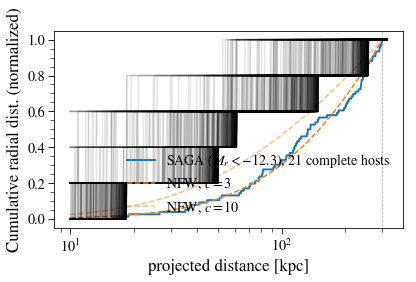

In [21]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

mwprojs = project_mc(SkyCoord(mcconn_mw['center']), 400)
for proj in mwprojs:
    plt.semilogx(rbins, np.searchsorted(proj.to(u.kpc).value, rbins)/len(proj), label=None, alpha=.1, c='k')

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized)')
plt.tight_layout()

What if we have *no* distance cut?

In [22]:
mcconn_tab['name']

Canis Major
Sagittarius dSph
Segue (I)
Ursa Major II
Bootes II
Segue II
Willman 1
Coma Berenices
Bootes III
LMC
SMC


(array([2., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 1., 2., 4., 1., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([  26.30267992,   55.68796702,   85.07325411,  114.45854121,
         143.8438283 ,  173.2291154 ,  202.6144025 ,  231.99968959,
         261.38497669,  290.77026378,  320.15555088,  349.54083798,
         378.92612507,  408.31141217,  437.69669926,  467.08198636,
         496.46727346,  525.85256055,  555.23784765,  584.62313474,
         614.00842184,  643.39370894,  672.77899603,  702.16428313,
         731.54957022,  760.93485732,  790.32014442,  819.70543151,
         849.09071861,  878.4760057 ,  907.8612928 ,  937.2465799 ,
      

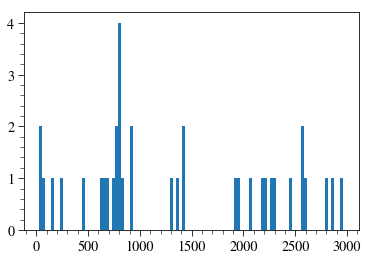

In [23]:
mcconn_nod = mcconn_tab[(mcconn_tab['rabs']<-12.3)&~np.in1d(mcconn_tab['name'].astype(str), ['Canis Major', 'Andromeda'])]
plt.hist(mcconn_nod['distance'], bins=100)

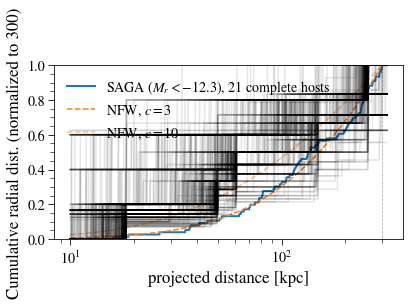

In [24]:
plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
for proj in mwprojs:
    n_at_r = np.searchsorted(proj.to(u.kpc).value, rbins)
    plt.semilogx(rbins, n_at_r/np.sum(proj<300*u.kpc), label=None, alpha=.1, c='k')

plt.axvline(300.0, c='k', ls=':', lw=0.5)
plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

Lets make the figure a bit cleaner

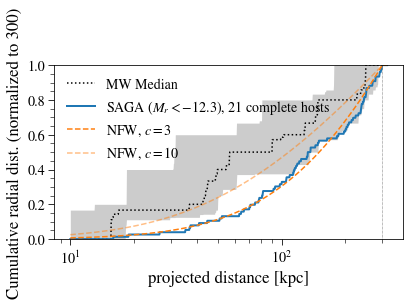

In [25]:
mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
percs_mw = []
nat300 = np.sum(mwprojs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(mwprojs < r, axis=1)/nat300
    percs_mw.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs_mw = np.array(percs_mw)

plt.plot(rbins, percs_mw[:, 1], label='MW Median', c='k', ls=':')
plt.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

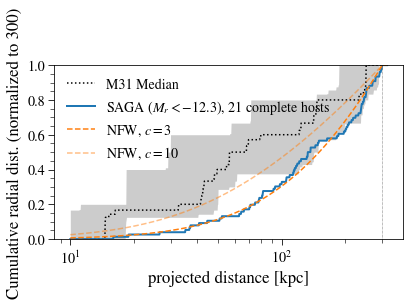

In [27]:
mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400)
percs = []
nat300 = np.sum(mwprojs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(mwprojs < r, axis=1)/nat300
    percs.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs = np.array(percs)

plt.plot(rbins, percs[:, 1], label='M31 Median', c='k', ls=':')
plt.fill_between(rbins, percs[:, 0], percs[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

### M31 

In [28]:
m31coo = mcconn_tab[mcconn_tab['name'] == 'Andromeda']['center'][0]
m31coo

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (10.68458333, 41.26916667, 783.42964277)>

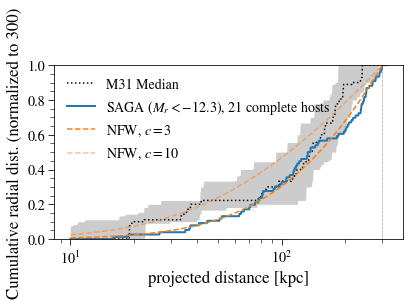

In [29]:
mwprojs = project_mc(SkyCoord(mcconn_nod['center']), 400, center=m31coo)
percs_m31 = []
nat300 = np.sum(mwprojs < 300*u.kpc, axis=1)
for r in rbins*u.kpc:
    n_distr_mv = np.sum(mwprojs < r, axis=1)/nat300
    percs_m31.append(np.percentile(n_distr_mv, [10, 50, 90]))
percs_m31 = np.array(percs_m31)

plt.plot(rbins, percs_m31[:, 1], label='M31 Median', c='k', ls=':')
plt.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='k', alpha=.2, lw=0)
    

plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA ($M_r < -12.3$), 21 complete hosts', lw=2)
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls='--')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C1', ls='--', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300)')
plt.ylim(0, 1)
plt.tight_layout()

### All together 

It's an entirely different kind of flying.

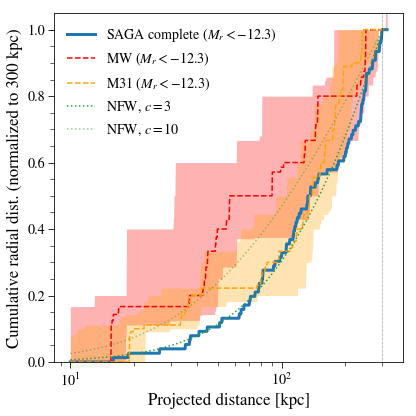

In [51]:
plt.figure(figsize=(6, 6))


plt.semilogx(rbins, np.searchsorted(r_kpc, rbins)/len(r_kpc), label='SAGA complete ($M_r < -12.3$)', lw=3,)

plt.plot(rbins, percs_mw[:, 1], label='MW ($M_r < -12.3$)', c='red', ls='--')
plt.fill_between(rbins, percs_mw[:, 0], percs_mw[:, 2], color='red', alpha=.3, lw=0)

plt.plot(rbins, percs_m31[:, 1], label='M31 ($M_r < -12.3$)', c='orange', ls='--')
plt.fill_between(rbins, percs_m31[:, 0], percs_m31[:, 2], color='orange', alpha=.3, lw=0)

plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 3)), label='NFW, $c=3$', ls=':', c='C2')
plt.semilogx(rbins, cap_at_one(nfw(rbins/300.0, 10)), label='NFW, $c=10$', c='C2', ls=':', alpha=0.5)

plt.axvline(300.0, c='k', ls=':', lw=0.5)

plt.legend()
plt.xlabel('Projected distance [kpc]')
plt.ylabel('Cumulative radial dist. (normalized to 300 kpc)')
plt.ylim(0, 1.05)
plt.tight_layout()

plt.savefig('../paperii/sat_radial.pdf')

# Luminosity Function

In [ ]:
#plt.savefig('../paperii/lfunc.pdf')